# 3. Top-K Sampling

In the last notebook, we saw that even with a low Temperature, there is still a tiny probability assigned to completely nonsensical words. This is because the Softmax function never truly outputs exactly 0.0.

If we get unlucky with our `torch.multinomial` random roll, we might pick one of those terrible words from the "long tail". 

**Top-K Sampling** solves this by simply truncating the tail. We take the top $K$ most likely tokens, throw the rest away (set their probability to 0), and then sample from what's left.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import sys
import os

sys.path.append(os.path.abspath('.'))
from metrics import calculate_entropy, track_probability_mass

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

model_id = "Qwen/Qwen2.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
model.eval()

Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

## Step 1: Getting Logits
We need our raw logits again.

In [2]:
prompt = "The key to successful artificial intelligence is"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

with torch.no_grad():
    outputs = model(input_ids)

logits = outputs.logits[0, -1, :]
print(f"Original logits max: {logits.max().item():.4f}, min: {logits.min().item():.4f}")

Original logits max: 19.6250, min: -9.6875


## Step 2: Implementing Top-K

To implement Top-K, we:
1. Find the probability of the $K$-th ranked token.
2. Find all tokens with a probability *lower* than that $K$-th token.
3. Set their logits to `-Infinity` (so when Softmax runs, they get exactly $0.0$).
4. Let the standard Softmax and multinomial handle the rest.

In [3]:
def apply_top_k(logits, k):
    # 1. Find the top K highest values
    top_k_values, top_k_indices = torch.topk(logits, k)
    
    # 2. Get the lowest value in our Top K (this is our cutoff)
    cutoff_value = top_k_values[-1]
    
    # 3. Create a mask: anywhere the logit is LESS than the cutoff, we overwrite it with -Inf
    indices_to_remove = logits < cutoff_value
    
    # Create a copy so we don't modify the original
    filtered_logits = logits.clone()
    filtered_logits[indices_to_remove] = -float('Inf')
    
    return filtered_logits

k_val = 10
filtered_logits = apply_top_k(logits, k_val)

print(f"After Top-{k_val}:")
print(f"Number of tokens with >0 probability: {(filtered_logits != -float('Inf')).sum().item()}")

After Top-10:
Number of tokens with >0 probability: 10


## Step 3: Top-K Generation Loop

Let's integrate this into our generation loop along with Temperature!

In [4]:
def top_k_generate(prompt, temperature=1.0, k=50, max_new_tokens=20):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    
    print(f"Prompt: '{prompt}' (T={temperature}, K={k})")
    print("Generating: ", end="")
    
    torch.manual_seed(42)
    
    for _ in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(input_ids)
            
        logits = outputs.logits[0, -1, :]
        
        # 1. Apply Temperature first
        logits = logits / temperature
        
        # 2. Apply Top-K truncation
        filtered_logits = apply_top_k(logits, k)
        
        # 3. Softmax and sample
        probs = F.softmax(filtered_logits, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1).unsqueeze(0)
        
        next_word = tokenizer.decode(next_token_id[0])
        print(next_word, end="", flush=True)
        
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)
        
    print("\n")
    return tokenizer.decode(input_ids[0])

print("=== The Limitation of Top-K ===")
print("If K=1, it's just greedy decoding:")
top_k_generate("A robot walked into a bar and ordered a", k=1, max_new_tokens=10)

print("If K=50, we get nicer variety, but what if there are only 3 valid next words?")
print("We are still allowing 47 bad words into the lottery bag!")
top_k_generate("A robot walked into a bar and ordered a", k=50, temperature=1.5, max_new_tokens=10)


=== The Limitation of Top-K ===
If K=1, it's just greedy decoding:
Prompt: 'A robot walked into a bar and ordered a' (T=1.0, K=1)
Generating:  drink. The bartender served the drink to the robot

If K=50, we get nicer variety, but what if there are only 3 valid next words?
We are still allowing 47 bad words into the lottery bag!
Prompt: 'A robot walked into a bar and ordered a' (T=1.5, K=50)
Generating:  Mojito drink.  For one Mojito drinking



'A robot walked into a bar and ordered a Mojito drink.  For one Mojito drinking'

## 🔬 Experimentation Ideas

1. **Compare K = 1, 5, 20, 100:**
   * *How does the output change as the lottery bag gets bigger?*
2. **Plot how many tokens have probability > 0.001:** before and after Top-K.
   * *Use the `metrics` module's `track_probability_mass` function to observe how much of the original "meaning" you throw away with a small K.*
3. **Try combining Top-K with low vs high temperature:**
   * *Does a very high temperature matter if K is very small?*
4. **Inspect cases where the correct next word is ranked outside small K.**
   * *Does Top-K accidentally remove reasonable tokens in highly creative prompts?*
5. **Visualize how often rare tokens are sampled with large K:**
   * *Run generation in a loop 100 times, save the token IDs, and plot their frequency.*

=== Experiment 1: The size of the lottery bag ===
[K=1, T=1.0]  drink. The bartender served the drink to the robot, but the robot refused to pay for it.

[K=5, T=1.0]  Mojito. It then asked if it could have the following:
- A Mojito with 1

[K=20, T=1.0]  Mojito. It has an alcohol concentration of 40%. If it drank 2 ounces of

[K=100, T=1.0]  revue. As it turned out, he heard the word revue twenty-three times. When he

=== Experiment 2: Truncated Probability Mass ===
Tokens > 0.1% prob (K=5): 5 (Original pool=138)
Tokens > 0.1% prob (K=20): 20 (Original pool=138)
Tokens > 0.1% prob (K=100): 101 (Original pool=138)

=== Experiment 3: High Temp vs Small K ===
Notice how at K=2, even a massive Temp=5.0 can only choose between two words!
[K=2, T=5.0]  drink. The bartender then handed him a glass with

[K=100, T=5.0]  revue for martin, an album documenting he's

=== Experiment 4 & 5: Visualizing Rare Tokens ===
Rolling the dice for the NEXT word 100 times with K=100...


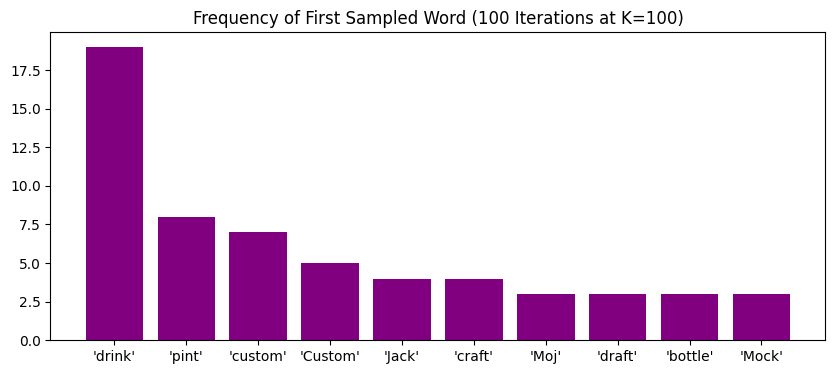

In [7]:
import matplotlib.pyplot as plt
# import torch
# import torch.nn.functional as F
from collections import Counter
# import sys
# import os
sys.path.append(os.path.abspath('.'))
from metrics import track_probability_mass

# device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
# model_id = "Qwen/Qwen2.5-0.5B"
# from transformers import AutoModelForCausalLM, AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

def apply_top_k_local(logits, k):
    top_k_values, top_k_indices = torch.topk(logits, k)
    cutoff = top_k_values[-1]
    filtered = logits.clone()
    filtered[logits < cutoff] = -float('Inf')
    return filtered

def top_k_generate_local(prompt, k=50, temp=1.0, max_tokens=20, return_counts=False):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    generated_tokens = []
    
    # Only suppress the K/T printout if we are mass generating
    if not return_counts: print(f"[K={k}, T={temp}] ", end="")
    
    # Explicitly do NOT lock the seed when returning counts, so we get varied rolls!
    if not return_counts: torch.manual_seed(42)

    for _ in range(max_tokens):
        with torch.no_grad():
            outputs = model(input_ids)
        logits = outputs.logits[0, -1, :] / temp
        filtered = apply_top_k_local(logits, k)
        probs = F.softmax(filtered, dim=-1)
        next_tok = torch.multinomial(probs, 1).unsqueeze(0)
        
        if return_counts:
            generated_tokens.append(next_tok.item())
        else:
            print(tokenizer.decode(next_tok[0]), end="", flush=True)
            
        input_ids = torch.cat([input_ids, next_tok], dim=-1)
        
    if not return_counts: print("\n")
    return generated_tokens

print("=== Experiment 1: The size of the lottery bag ===")
prompt = "A robot walked into a bar and ordered a"
top_k_generate_local(prompt, k=1, temp=1.0)
top_k_generate_local(prompt, k=5, temp=1.0)
top_k_generate_local(prompt, k=20, temp=1.0)
top_k_generate_local(prompt, k=100, temp=1.0)

print("=== Experiment 2: Truncated Probability Mass ===")
input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
with torch.no_grad(): out = model(input_ids)
logits = out.logits[0, -1, :]
probs_before = F.softmax(logits, dim=-1)
count_before = (probs_before > 0.001).sum().item()

k_vals = [5, 20, 100]
for k in k_vals:
    filtered = apply_top_k_local(logits, k)
    probs_after = F.softmax(filtered, dim=-1)
    count_after = (probs_after > 0.001).sum().item()
    print(f"Tokens > 0.1% prob (K={k}): {count_after} (Original pool={count_before})")

print("\n=== Experiment 3: High Temp vs Small K ===")
print("Notice how at K=2, even a massive Temp=5.0 can only choose between two words!")
top_k_generate_local(prompt, k=2, temp=5.0, max_tokens=10)
top_k_generate_local(prompt, k=100, temp=5.0, max_tokens=10)

print("=== Experiment 4 & 5: Visualizing Rare Tokens ===")
print("Rolling the dice for the NEXT word 100 times with K=100...")
all_tokens = []
for _ in range(100):
    toks = top_k_generate_local(prompt, k=100, temp=1.0, max_tokens=1, return_counts=True)
    all_tokens.extend(toks)

counts = Counter(all_tokens)
top_to_plot = counts.most_common(10)
labels = [repr(tokenizer.decode([t]).strip()) for t, c in top_to_plot]
vals = [c for t, c in top_to_plot]
plt.figure(figsize=(10,4))
plt.bar(labels, vals, color='purple')
plt.title('Frequency of First Sampled Word (100 Iterations at K=100)')
plt.show()
